In [31]:
%load_ext autoreload #any changes in the source code will be automatically loaded
%autoreload 2

%matplotlib inline

ModuleNotFoundError: No module named 'autoreload #any changes in the source code will be automatically loaded'

In [32]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from treeinterpreter import treeinterpreter as ti
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from scipy.cluster import hierarchy as hc


In [96]:
from IPython.core.debugger import set_trace

## Preprocessing steps:
* Load data
* Extract columns from date columns
* Fill in missing values
* for continuous : median and add a column for missing
* Convert categorical to continous

## Data loading and pre-processing

In [33]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [34]:
data = pd.read_csv('data/kc_house_data.csv',parse_dates=['date'])

In [35]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,2014-12-09,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,2015-02-25,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,2014-12-09,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,2015-02-18,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


In [36]:
data.shape

(21613, 21)

In [37]:
data.dtypes #many categorical variables stored as object 

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [38]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [39]:
add_datepart(data, 'date') #extracting info from the date columns


In [40]:
#converts categorical type columns to categorical type
def convert_to_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [41]:
#apply_cats() for applying the same categorical code to test data

In [42]:
convert_to_cats(data)

In [43]:
data.dtypes

id                    int64
price               float64
bedrooms              int64
bathrooms           float64
sqft_living           int64
sqft_lot              int64
floors              float64
waterfront            int64
view                  int64
condition             int64
grade                 int64
sqft_above            int64
sqft_basement         int64
yr_built              int64
yr_renovated          int64
zipcode               int64
lat                 float64
long                float64
sqft_living15         int64
sqft_lot15            int64
Year                  int64
Month                 int64
Week                  int64
Day                   int64
Dayofweek             int64
Dayofyear             int64
Is_month_end           bool
Is_month_start         bool
Is_quarter_end         bool
Is_quarter_start       bool
Is_year_end            bool
Is_year_start          bool
Elapsed               int64
dtype: object

In [44]:
data.apply(lambda x: x.nunique()) #number of unique values for each column

id                  21436
price                4028
bedrooms               13
bathrooms              30
sqft_living          1038
sqft_lot             9782
floors                  6
waterfront              2
view                    5
condition               5
grade                  12
sqft_above            946
sqft_basement         306
yr_built              116
yr_renovated           70
zipcode                70
lat                  5034
long                  752
sqft_living15         777
sqft_lot15           8689
Year                    2
Month                  12
Week                   52
Day                    31
Dayofweek               7
Dayofyear             356
Is_month_end            2
Is_month_start          2
Is_quarter_end          2
Is_quarter_start        2
Is_year_end             2
Is_year_start           1
Elapsed               372
dtype: int64

In [45]:
data.isnull().sum() #missing value for each column

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
Year                0
Month               0
Week                0
Day                 0
Dayofweek           0
Dayofyear           0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
Elapsed             0
dtype: int64

In [46]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,7129300520,221900.00000,3,1.00000,1180,5650,1.00000,0,0,3,...,13,0,286,False,False,False,False,False,False,1413158400
1,6414100192,538000.00000,3,2.25000,2570,7242,2.00000,0,0,3,...,9,1,343,False,False,False,False,False,False,1418083200
2,5631500400,180000.00000,2,1.00000,770,10000,1.00000,0,0,3,...,25,2,56,False,False,False,False,False,False,1424822400
3,2487200875,604000.00000,4,3.00000,1960,5000,1.00000,0,0,5,...,9,1,343,False,False,False,False,False,False,1418083200
4,1954400510,510000.00000,3,2.00000,1680,8080,1.00000,0,0,3,...,18,2,49,False,False,False,False,False,False,1424217600


In [47]:
data['price'] = np.log(data['price']) #converting price to log price

In [48]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,7129300520,12.30998,3,1.00000,1180,5650,1.00000,0,0,3,...,13,0,286,False,False,False,False,False,False,1413158400
1,6414100192,13.19561,3,2.25000,2570,7242,2.00000,0,0,3,...,9,1,343,False,False,False,False,False,False,1418083200
2,5631500400,12.10071,2,1.00000,770,10000,1.00000,0,0,3,...,25,2,56,False,False,False,False,False,False,1424822400
3,2487200875,13.31133,4,3.00000,1960,5000,1.00000,0,0,5,...,9,1,343,False,False,False,False,False,False,1418083200
4,1954400510,13.14217,3,2.00000,1680,8080,1.00000,0,0,3,...,18,2,49,False,False,False,False,False,False,1424217600


In [49]:
def process(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [50]:
x,y,nas = process(data,'price')

In [51]:
x.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,7129300520,3,1.00000,1180,5650,1.00000,0,0,3,7,...,13,0,286,False,False,False,False,False,False,1413158400
1,6414100192,3,2.25000,2570,7242,2.00000,0,0,3,7,...,9,1,343,False,False,False,False,False,False,1418083200
2,5631500400,2,1.00000,770,10000,1.00000,0,0,3,6,...,25,2,56,False,False,False,False,False,False,1424822400
3,2487200875,4,3.00000,1960,5000,1.00000,0,0,5,7,...,9,1,343,False,False,False,False,False,False,1418083200
4,1954400510,3,2.00000,1680,8080,1.00000,0,0,3,8,...,18,2,49,False,False,False,False,False,False,1424217600


In [58]:
pd.Series(y)

0       12.30998
1       13.19561
2       12.10071
3       13.31133
4       13.14217
5       14.01845
6       12.45877
7       12.58400
8       12.34366
9       12.68541
10      13.40378
11      13.05622
12      12.64433
13      12.89922
14      13.18063
15      13.38473
16      12.88664
17      13.09190
18      12.14950
19      12.34583
20      12.86100
21      14.50866
22      12.56024
23      12.43996
24      12.70381
25      12.35879
26      13.75044
27      13.41055
28      12.98997
29      13.48562
          ...   
21583   12.89909
21584   12.84793
21585   12.50618
21586   13.13231
21587   12.86100
21588   12.93483
21589   12.75852
21590   14.01641
21591   13.25689
21592   13.07107
21593   13.89985
21594   12.76569
21595   13.16158
21596   13.42977
21597   14.26977
21598   13.20265
21599   13.60479
21600   14.24534
21601   13.05408
21602   12.31940
21603   13.13676
21604   12.96921
21605   13.32234
21606   13.82298
21607   13.07107
21608   12.79386
21609   12.89922
21610   12.904

In [60]:
df_raw = pd.concat([x,pd.Series(y)],axis=1)#combining processed x and y

In [61]:
df_raw.shape

(21613, 33)

In [62]:
df_raw = df_raw.rename(columns={0:'price'})

In [63]:
os.makedirs('data/tmp',exist_ok=True)

In [64]:
df_raw.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'price'],
      dtype='object')

In [65]:
df_raw.to_feather('data/tmp/housing') #storing feather format

---

## Building model

## Basic model

In [114]:
m = RandomForestRegressor(n_jobs=-1) #regressor means it's trying to predict a continuous variable
m.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [115]:
m.score(x,y)

0.97771905634535461

## Train - Valid split

In [121]:
def split(df,test_size,y_var):
    df_train, df_valid = train_test_split(df, test_size = test_size)
    X_train,Y_train = df_train.drop([y_var],axis = 1),df_train[y_var].values
    X_valid,Y_valid = df_valid.drop([y_var],axis = 1),df_valid[y_var].values
    return X_train,Y_train,X_valid,Y_valid

In [122]:
X_train,Y_train,X_valid,Y_valid = split(df=df_raw, test_size = .2 ,y_var='price')

In [123]:
X_train.shape, X_valid.shape

((17290, 32), (4323, 32))

----

In [124]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), Y_train), rmse(m.predict(X_valid), Y_valid),
                m.score(X_train, Y_train), m.score(X_valid, Y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [125]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, Y_train)
print_score(m)

CPU times: user 3.25 s, sys: 46.1 ms, total: 3.3 s
Wall time: 1.11 s
[0.08112146604034669, 0.18286386513076308, 0.97625491312613522, 0.87986882823089685]


## Single Tree

##### Split at each node happens based on which split results in maximum decrease in weighted MSE for the 2 resultant nodes

In [93]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=1,bootstrap=False)
%time m.fit(X_train, Y_train)
print_score(m)

CPU times: user 454 ms, sys: 10.9 ms, total: 465 ms
Wall time: 561 ms
[1.7628040339622753e-05, 0.2554040361383808, 0.99999999887778257, 0.76599948264091833]


We can see that single tree is overfitting badly

## Bagging  

In [94]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=20)
%time m.fit(X_train, Y_train)
print_score(m)

CPU times: user 6.91 s, sys: 55.8 ms, total: 6.97 s
Wall time: 2.01 s
[0.07130924796557529, 0.1803164788337486, 0.98163628117761892, 0.88336412778879647]


### Parameter tuning without grid search

#### n_estimators

In [95]:
#pass the maximum number of estimators till which you want to try
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[0.0660139700471889, 0.17657545200408176, 0.98426232308469186, 0.88815361322604536]


In [97]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

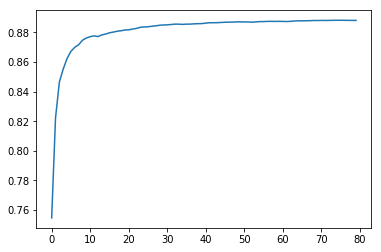

In [98]:
plt.plot([metrics.r2_score(Y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

##### Based on this plot you can chose the number of estimators

#### Minimum sample leaf and max_features

In [99]:
def rf_tuning(l,f):
    print(l,f)
    m = RandomForestRegressor(n_estimators=20, n_jobs=-1,min_samples_leaf=l,max_features=f)
    m.fit(X_train, Y_train)
    print_score(m)

In [100]:
grid = [(3,'auto'),(5,'auto'),(10,'auto')]

In [101]:
for l,f in grid:
    rf_tuning(l,f)

3 auto
[0.09657541283640379, 0.17962186483109116, 0.96631767451139228, 0.8842610049256846]
5 auto
[0.11756387278384976, 0.1799478232467421, 0.95008665334525888, 0.88384056245750142]
10 auto
[0.14507428087937435, 0.18448623587475466, 0.92399366794877402, 0.87790742728744986]


Looks like min sample leaf size = 3 is better

### SKlearn grid search

In [109]:
param_grid = {"max_features": ['auto','sqrt','log2',None],
              "min_samples_leaf": [2,3,5,10]}

rf = RandomForestRegressor(random_state=50, n_jobs = -1,n_estimators=20)

random_cv = GridSearchCV(rf, param_grid = param_grid, cv= 3, scoring=metrics.make_scorer(metrics.r2_score),verbose=5)
random_cv.fit(X_train,Y_train)

print(random_cv.best_score_)
print(random_cv.best_params_)
print(random_cv.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_features=auto, min_samples_leaf=2 ...........................
[CV]  max_features=auto, min_samples_leaf=2, score=0.8780621041428922, total=   1.3s
[CV] max_features=auto, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, score=0.8761442434056345, total=   1.3s
[CV] max_features=auto, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=2, score=0.8773888323017978, total=   1.2s
[CV] max_features=auto, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=3, score=0.8779042055149371, total=   1.2s
[CV] max_features=auto, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=3, score=0.8754047188698528, total=   1.2s
[CV] max_features=auto, min_samples_leaf=3 ...........................
[CV]  max_features=auto, min_samples_leaf=3, score=0.8764688490714372, total=   1.3s
[CV] max_features=auto, min_samples_leaf=5 ...........................
[CV]  max_features=auto, min_samples_leaf=5, score=0.8758096489716543, total=   1.2s
[CV] max_features=auto, min_samples_leaf=5 ...........................
[CV]  max_features=auto, min_samples_leaf=5, score=0.8741053955476611, total=   1.1s
[CV] max_features=auto, min_samples_leaf=5 ...........................
[CV]  max_features=auto, min_samples_leaf=5, score=0.8741918753227271, total=   1.2s
[CV] max_features=auto, min_samples_leaf=10 ..........................
[CV]  max_features=auto, min_samples_leaf=10, score=0.8701482293908636, total=   1.0s
[CV] max_features=auto, min_samples_leaf=10 ..........................
[CV]  max_features=auto, min_samples_leaf=10, score=0.866602973

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   45.9s finished


0.877198443238
{'max_features': 'auto', 'min_samples_leaf': 2}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=50, verbose=0, warm_start=False)


## OOB score

##### On an average OOB score should be less than the validation score as rows will be less appearing for each tree therefore bagging will be less efficient

In [126]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40,oob_score=True,max_features='auto',min_samples_leaf=2)
%time m.fit(X_train, Y_train)
print_score(m)

CPU times: user 12 s, sys: 81.8 ms, total: 12.1 s
Wall time: 3.42 s
[0.0819835740630189, 0.17471579319142216, 0.97574753557336136, 0.8903359573835421, 0.87998623413962962]


## Reduce over fitting

### Subsampling

##### One of the hyper parameter: if you increase you are increasing the correlation but also improving predictive power of each tree

In [ ]:
set_rf_samples(14000)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1,min_samples_leaf=4,max_features=.5)
m.fit(X_train, y_train)
print_score(m)

## Confidence based on tree variance

In [112]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.08071234141388627, 0.1771216649806026, 0.97647396093183325, 0.88746057875156892, 0.88077493464948464]


In [113]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 387 ms, sys: 4.62 ms, total: 391 ms
Wall time: 396 ms


(12.390191176299941, 0.15100332324342983)

In [114]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds)) #speed up the computation
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 67.4 ms, sys: 82.1 ms, total: 149 ms
Wall time: 418 ms


(12.390191176299941, 0.15100332324342983)

In [115]:
preds.shape

(40, 4323)

In [116]:
valid_raw = pd.concat([X_valid.reset_index(),pd.DataFrame(Y_valid)],axis=1)

In [117]:
valid_raw['pred_std'] = np.std(preds, axis=0)
valid_raw['pred'] = np.mean(preds, axis=0)

In [118]:
valid_raw = valid_raw.rename(columns={0: 'price'})

In [120]:
valid_raw.columns

Index(['index', 'id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'price', 'pred_std', 'pred'],
      dtype='object')

In [123]:
flds = ['view', 'price', 'pred', 'pred_std']
view_summ = valid_raw[flds].groupby('view', as_index=False).mean()
view_summ

,view,price,pred,pred_std
0,0,12.96945,12.98039,0.16181
1,1,13.49653,13.50136,0.22627
2,2,13.43859,13.43049,0.21534
3,3,13.61497,13.54730,0.24163
4,4,13.95756,13.82083,0.30403


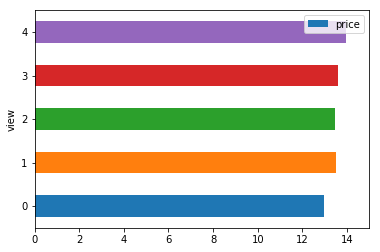

In [128]:
view_summ = view_summ[~pd.isnull(view_summ.price)]
view_summ.plot('view', 'price', 'barh', xlim=(0,15));

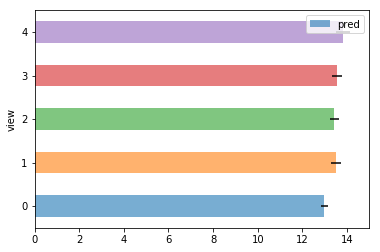

In [129]:
view_summ.plot('view', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,15));

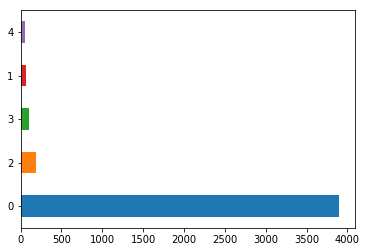

In [130]:
valid_raw.view.value_counts().plot.barh();

In [131]:
(view_summ.pred_std/view_summ.pred).sort_values(ascending=False) #ratio if deviation as proportion of mean

4   0.02200
3   0.01784
1   0.01676
2   0.01603
0   0.01247
dtype: float64

## Feature Importance

Feature importance is calculated based on shuffling logic 

In [133]:
def feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [135]:
fi = feat_importance(m, X_train); fi[:15]

,cols,imp
9,grade,0.34757
15,lat,0.28773
3,sqft_living,0.17890
16,long,0.04200
17,sqft_living15,0.02381
12,yr_built,0.01904
4,sqft_lot,0.01336
10,sqft_above,0.01188
18,sqft_lot15,0.01175
14,zipcode,0.00924


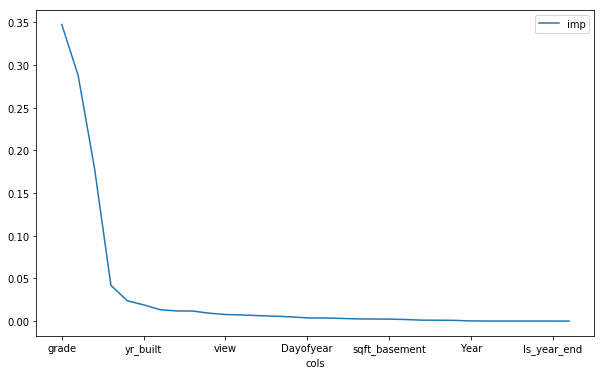

In [137]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True);

In [138]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

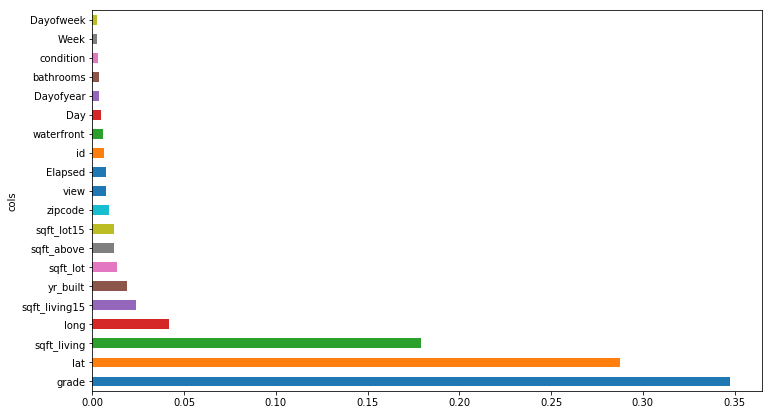

In [139]:
plot_fi(fi[:20]);

In [162]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

14

In [163]:
to_keep = list(to_keep)

In [168]:
df_keep = df_raw[to_keep].copy()
X_train,Y_train,X_valid,Y_valid = split(df=df_keep, test_size = .2 ,y_var='price')

In [169]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.08238501484499755, 0.1843826714501354, 0.97558978826324294, 0.87619661254037673, 0.88171562607476817]


In [170]:
fi = feat_importance(m, X_train); fi[:15]

,cols,imp
0,grade,0.35584
1,lat,0.29097
2,sqft_living,0.17562
3,long,0.04844
4,sqft_living15,0.02406
5,yr_built,0.01905
6,sqft_lot,0.01597
7,sqft_above,0.01531
8,sqft_lot15,0.01265
11,Elapsed,0.01105


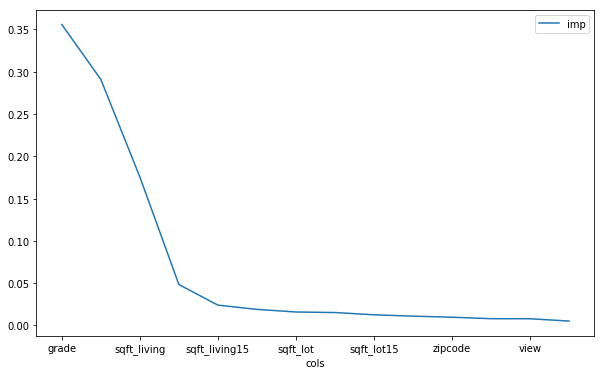

In [171]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True);

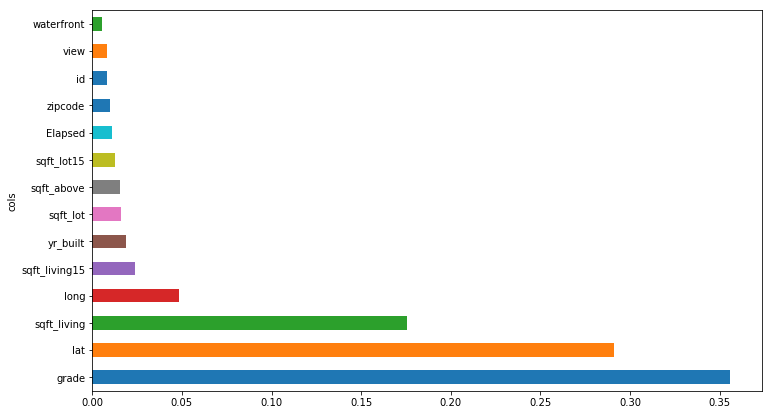

In [173]:
plot_fi(fi[:20]);

##### One Hot encoding: If a particular categorical variable has low levels and one particular level is specifically important, one hot encoded is the preferred choice. That particular variable can be converted using pd.getdummies in the pre-processing step. For models like linear or logistic regression this kind of encoding is a must

## Removing redundant features

In [174]:
from scipy.cluster import hierarchy as hc

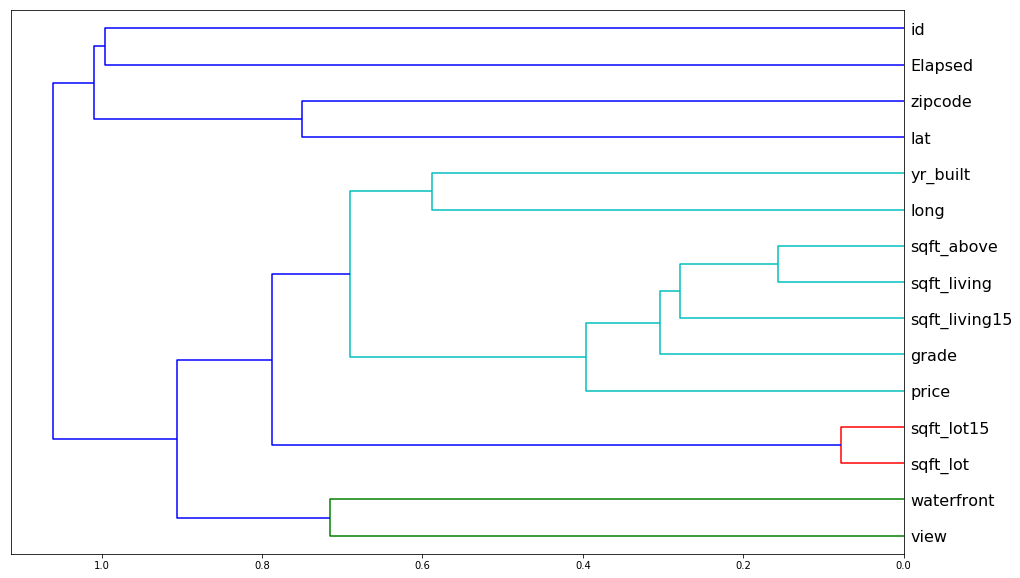

In [175]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [177]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1, oob_score=True)
    X_train,Y_train,X_valid,Y_valid= split(df,.2,'price')
    m.fit(X_train, Y_train)
    return m.oob_score_

In [178]:
get_oob(df_keep)

0.87871587909857929

In [179]:
for c in ('sqft_lot15', 'sqft_lot', 'sqft_above', 'sqft_living'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

sqft_lot15 0.881278073418
sqft_lot 0.880768628565
sqft_above 0.881292887707
sqft_living 0.865580734055


In [180]:
to_drop = ['sqft_lot15', 'sqft_above']
get_oob(df_keep.drop(to_drop, axis=1))

0.88011895217478442

In [181]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train,Y_train,X_valid,Y_valid= split(df_keep, .2,'price')

In [183]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.08396274852209079, 0.17983289400240826, 0.97437839738462151, 0.88699219904691795, 0.8792187821596289]


## Partial dependence plot

In [184]:
from pdpbox import pdp
from plotnine import *

In [185]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1)
m.fit(X_train, Y_train);

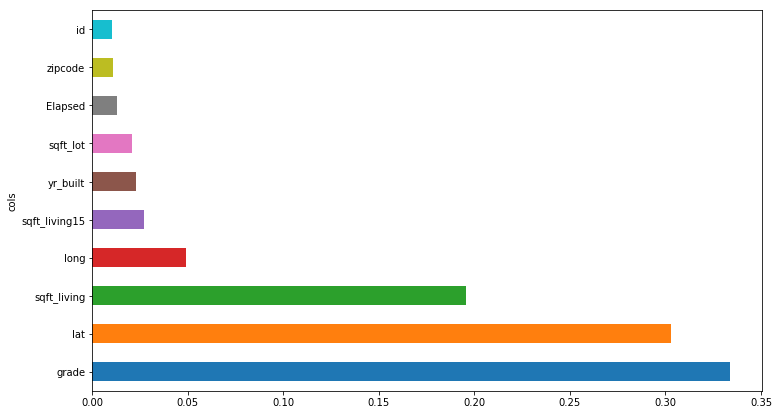

In [186]:
plot_fi(feat_importance(m, X_train)[:10]);

In [189]:
x_all = get_sample(df_keep, 500)

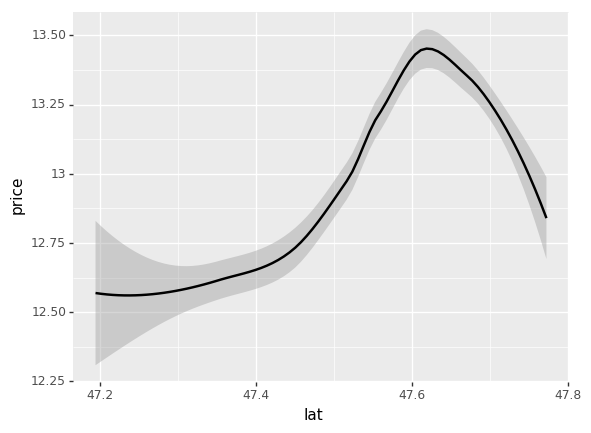

<ggplot: (-9223372029302221010)>

In [200]:
ggplot(x_all, aes('lat', 'price'))+stat_smooth(se=True, method='loess')

In [204]:
x = get_sample(X_train, 1000)

In [205]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

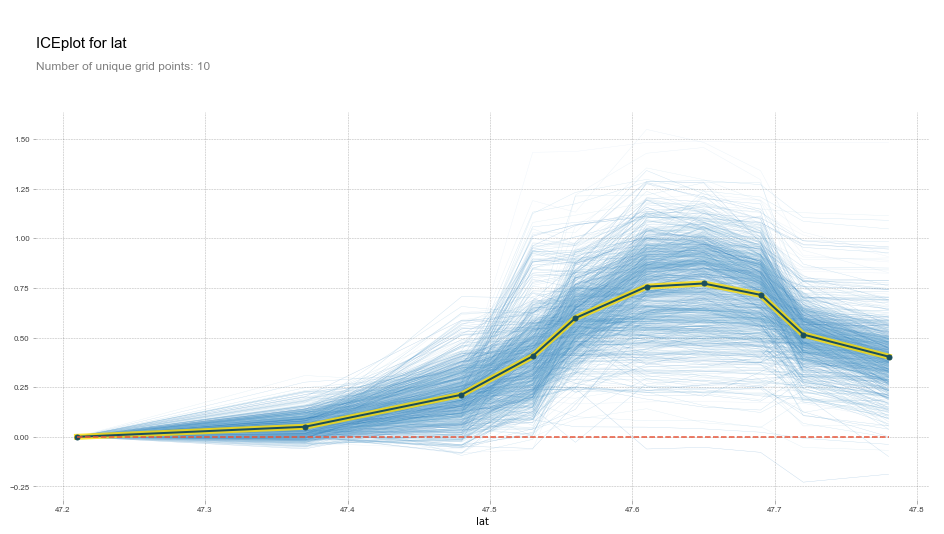

In [206]:
plot_pdp('lat')

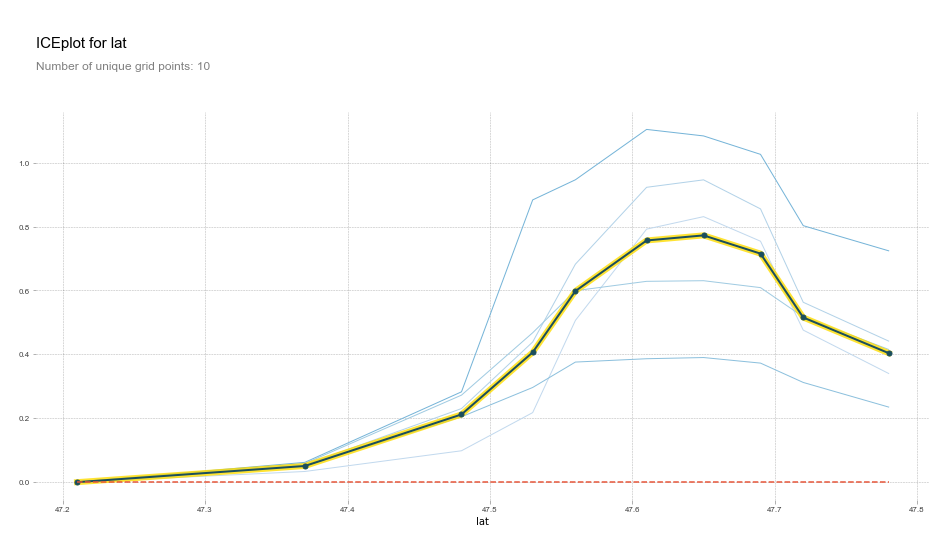

In [207]:
plot_pdp('lat', clusters=5)

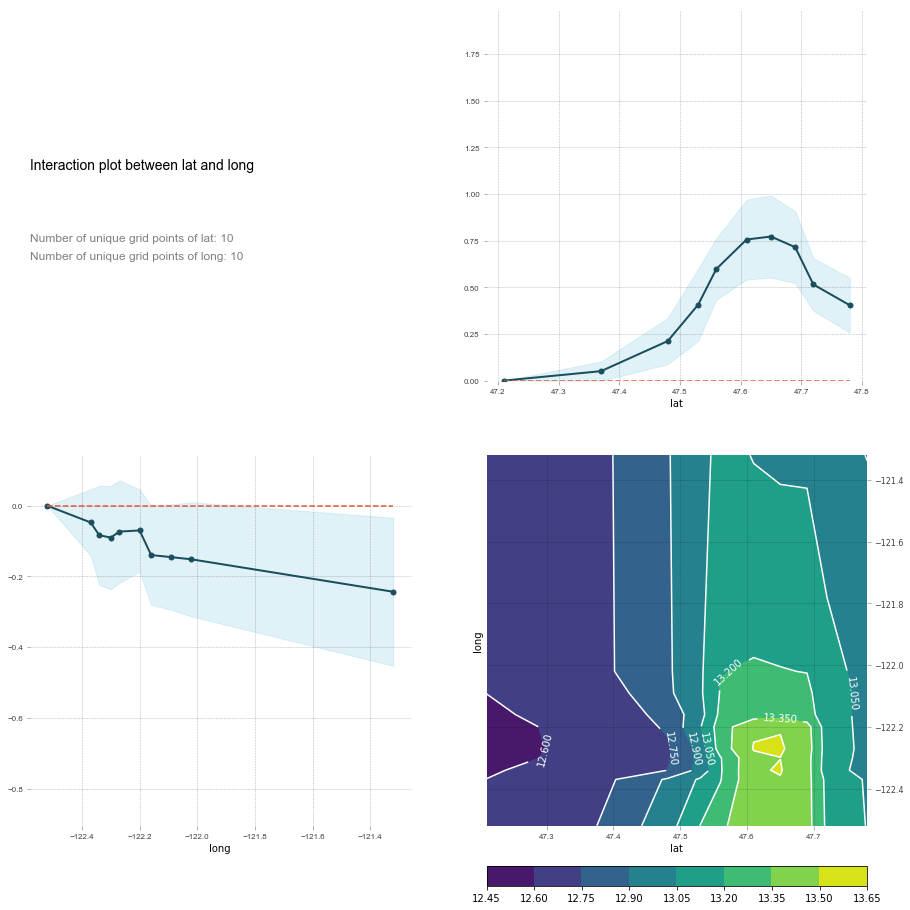

In [208]:
feats = ['lat', 'long']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

## Tree interpreter

In [209]:
from treeinterpreter import treeinterpreter as ti

In [210]:
row = X_valid.values[None,0]; row

array([[  1.10000e+01,   4.75862e+01,   4.46000e+03,  -1.21970e+02,   4.54000e+03,   2.00100e+03,
          1.62710e+04,   9.80750e+04,   2.00000e+00,   1.41212e+09,   9.80009e+07,   0.00000e+00]])

In [211]:
prediction, bias, contributions = ti.predict(m, row)

In [215]:
idxs = np.argsort(contributions[0])

In [217]:
prediction

array([ 13.93601])

In [218]:
bias

array([ 13.0451])

In [216]:
[o for o in zip(df_keep.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs])]

[('long', -121.97, -0.21360571494453731),
 ('zipcode', 98075.0, -0.037617865850017293),
 ('sqft_lot', 16271.0, -0.020208090674420955),
 ('waterfront', 0.0, -0.01864441350294448),
 ('id', 98000870.0, -0.015095845282456199),
 ('yr_built', 2001.0, -0.0043409338215206986),
 ('Elapsed', 1412121600.0, 0.00069969655091051131),
 ('sqft_living15', 4540.0, 0.017920807765974579),
 ('view', 2.0, 0.024237628640971343),
 ('lat', 47.5862, 0.091461496229743894),
 ('sqft_living', 4460.0, 0.41291492665783547),
 ('grade', 11.0, 0.65319636335859921)]

## Extrapolation

In [219]:
x_trn = X_train.copy()

In [220]:
x_trn['is_valid'] = 0

In [221]:
x_val = X_valid.copy()

In [222]:
x_val['is_valid'] = 1

In [223]:
df_ext = pd.concat([x_trn,x_val],axis=0)

In [226]:
x,y,nas = process(df_ext,'is_valid')

In [227]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=2, max_features='auto', n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.78984870216999026

In [228]:
fi = feat_importance(m, x); fi[:10]

,cols,imp
10,id,0.12119
6,sqft_lot,0.12115
9,Elapsed,0.12049
1,lat,0.11917
2,sqft_living,0.11625
4,sqft_living15,0.10988
3,long,0.10807
5,yr_built,0.09432
7,zipcode,0.05561
0,grade,0.02409


In [229]:
feats=['id', 'Elapsed', 'sqft_lot']

In [230]:
(X_train[feats]/1000).describe()

,id,Elapsed,sqft_lot
count,17290.00000,17290.00000,17290.00000
mean,4588601.60408,1414512.27151,15.05691
std,2876062.61504,9755.18962,40.50885
min,1000.10200,1398988.80000,0.52000
25%,2126059.22275,1405987.20000,5.04000
50%,3904960.80500,1413417.60000,7.62150
75%,7308900.35875,1424131.20000,10.62750
max,9900000.19000,1432684.80000,1164.79400


In [231]:
(X_valid[feats]/1000).describe()

,id,Elapsed,sqft_lot
count,4323.00000,4323.00000,4323.00000
mean,4547105.02797,1414738.30285,15.30718
std,2878669.85167,9814.87647,44.88640
min,1200.02100,1398988.80000,0.60900
25%,2025750.25500,1405987.20000,5.04150
50%,3897100.17000,1413849.60000,7.56500
75%,7308750.27000,1424217.60000,10.80050
max,9842300.54000,1431561.60000,1651.35900


##### Ideas is to loop through each of them and see the score

## RF from scratch

In [274]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [270]:
x_sub = X_train[['grade','yr_built']]

In [273]:
np.random.permutation(100)[:50]

array([98, 83, 84,  5, 60,  2, 74, 85, 96, 50, 63, 15, 19,  7, 62, 41, 39, 80, 66, 13, 70, 34, 57, 18, 78, 55,
       90, 65, 48, 27, 16, 53, 51, 87, 12, 36, 95, 71, 88, 38, 10, 54, 33, 73, 40, 67, 77, 61, 86, 44])

In [ ]:
class tree_ensemble():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf = 3):
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs],self.y[idxs],idxs = np.array(range(self.sample_sz)),min_leaf = self.min_leaf )
    
    
    
    def predict(x):
        return np.mean([t.predict(x) for t in self.trees],axis = 0)
        
        

In [ ]:
class DecisionTree():
    def __init__(self,x,y,idxs=None,min_leaf = 5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s 
         

----

### Find optimal split

In [112]:
def best_split(df,var_x,var_y): 
    df_subset = df.loc[:,[var_x,var_y]]
    current_score = np.std(df_subset[var_y])
    for i in df_subset[var_x].unique():
        lhs = df_subset[var_y][df_subset[var_x]<=i]
        rhs = df_subset[var_y][df_subset[var_x]>i]
        if len(rhs)==0:continue
        new_score = (len(lhs)*np.std(lhs)+len(rhs)*np.std(rhs))/df_subset.shape[0]
        if new_score < current_score:
            current_score = new_score
            var_x_best = i
    return var_x_best,current_score

In [211]:
df_raw.head(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,price
0,7129300520,3,1.00000,1180,5650,1.00000,0,0,3,7,...,0,286,False,False,False,False,False,False,1413158400,12.30998
1,6414100192,3,2.25000,2570,7242,2.00000,0,0,3,7,...,1,343,False,False,False,False,False,False,1418083200,13.19561


In [113]:
best_split(df_raw,'sqft_lot','price')

(12560, 0.5140738039169727)

----

### Feature importance calculation from scratch

##### Idea: Build your model and calculate the baseline score on validation set. Now for each feature, randomly shuffle that particular feature and then predict on this validation data with shuffled feature and calculate the score. The difference between the baseline score and the new score tells you the feature importance

In [157]:
#build a random forest model and calculate the baseline score
m = RandomForestRegressor(n_jobs=-1,n_estimators=40,oob_score=True,max_features='auto',min_samples_leaf=2)
%time m.fit(X_train, Y_train)
print_score_mod(m,X_valid)

CPU times: user 12 s, sys: 95.2 ms, total: 12.1 s
Wall time: 3.7 s
[0.08101031375221635, 0.17327372829393253, 0.97631993938055572, 0.89213877127324059, 0.87891546403830223]


In [209]:
def feature_importance_scratch(m,X_valid,Y_valid,metric='rmse'):
    
    f_importance = {}
    
    if metric == 'rmse': base_score = rmse(m.predict(X_valid), Y_valid)
    elif metric == 'r2': base_score = m.score(X_valid,Y_valid)

    for f in X_valid.columns:
        X_valid_shuff = X_valid.copy()
        X_valid_shuff[f] = np.random.permutation(X_valid_shuff[f])
        
        if metric == 'rmse': delta = rmse(m.predict(X_valid_shuff), Y_valid)-base_rmse
        elif metric == 'r2': delta =  base_r2 -  m.score(X_valid_shuff, Y_valid)

        f_importance[f] = delta
        imp_df = pd.DataFrame.from_dict(f_importance,'index')
        imp_df = imp_df.reset_index()
        imp_df = imp_df.rename(columns={0:'importance','index':'feature'})
        imp_df = imp_df.sort_values(by='importance',ascending=False)
        
    imp_df.plot('feature', 'importance', 'barh', figsize=(12,7), legend=False)
        
    return imp_df

,feature,importance
15,lat,0.74073
3,sqft_living,0.32156
9,grade,0.26657
16,long,0.17147
12,yr_built,0.10352
17,sqft_living15,0.10124
7,view,0.09295
14,zipcode,0.09177
4,sqft_lot,0.09162
10,sqft_above,0.09097


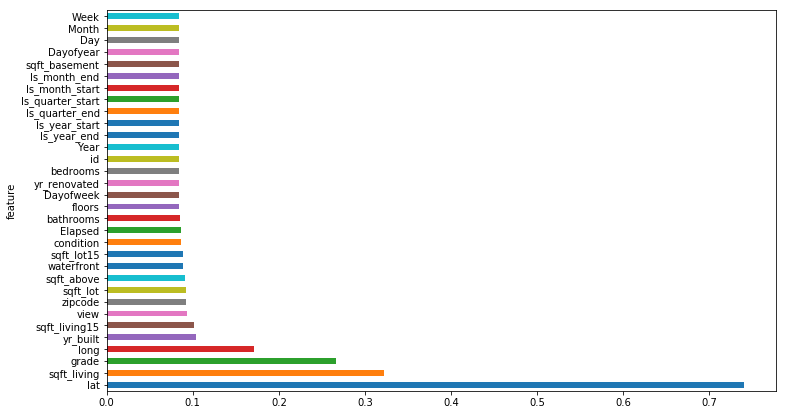

In [210]:
feature_importance_scratch(m,X_valid,Y_valid,'r2')

### Scikit RF feature importance

In [201]:
def feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [202]:
fi = feat_importance(m, X_train); fi

,cols,imp
9,grade,0.35199
15,lat,0.28466
3,sqft_living,0.17747
16,long,0.04353
17,sqft_living15,0.02294
12,yr_built,0.01871
4,sqft_lot,0.01313
10,sqft_above,0.01151
18,sqft_lot15,0.01124
14,zipcode,0.00943
